In [65]:
import warnings, statsmodels
from statsmodels.tools.sm_exceptions import ValueWarning
warnings.filterwarnings("ignore",
                        message="No frequency information was provided",
                        category=ValueWarning)

In [67]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller, kpss

plt.rcParams["figure.figsize"] = (7,4)

# ----------------------------------------------------------
# 1) Loading the cleaned levels file
# ----------------------------------------------------------
path = "/Users/junnu/Downloads/msvar_levels.csv"  
df   = pd.read_csv(path, index_col=0, parse_dates=True) \
         .rename(columns={'fx_usdinr':'fx',
                          'credit_nonfood_inrbn':'credit'})

# ----------------------------------------------------------
# 2) Stationarity checks (ADF & KPSS, one line each)
# ----------------------------------------------------------
def test(series, name):
    adf_p   = adfuller(series.dropna())[1]
    kpss_p  = kpss(series.dropna(), nlags="auto")[1]
    print(f"{name:10s}:  ADF-p={adf_p:6.4f}   KPSS-p={kpss_p:6.4f}")

print("Initial level series:")
test(df["fx"],     "FX")
test(df["credit"], "Credit")

# ----------------------------------------------------------
# 3) Transform only the credit series (log-difference)
#    → matches exponential-looking drift
# ----------------------------------------------------------
df["credit_ld"] = np.log(df["credit"]).diff()

# Final dataset for VAR
data = df[["fx", "credit_ld"]].dropna()
print("Sample length after diff:", len(data))

Initial level series:
FX        :  ADF-p=0.7432   KPSS-p=0.0100
Credit    :  ADF-p=0.9971   KPSS-p=0.0100
Sample length after diff: 197


/var/folders/kf/c7rps2xx2vlchx18pnqqjcq40000gn/T/ipykernel_13412/2558941895.py:20: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_p  = kpss(series.dropna(), nlags="auto")[1]
/var/folders/kf/c7rps2xx2vlchx18pnqqjcq40000gn/T/ipykernel_13412/2558941895.py:20: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_p  = kpss(series.dropna(), nlags="auto")[1]


In [69]:
# FX still look non-stationary
test(df["fx"].diff().dropna(), "FX_diff")      # ← quick check


FX_diff   :  ADF-p=0.0000   KPSS-p=0.1000


/var/folders/kf/c7rps2xx2vlchx18pnqqjcq40000gn/T/ipykernel_13412/2558941895.py:20: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_p  = kpss(series.dropna(), nlags="auto")[1]


In [71]:
print("\nAfter transforms:")
for col in data:
    test(data[col], col)



After transforms:
fx        :  ADF-p=0.6903   KPSS-p=0.0100
credit_ld :  ADF-p=0.0470   KPSS-p=0.1000


/var/folders/kf/c7rps2xx2vlchx18pnqqjcq40000gn/T/ipykernel_13412/2558941895.py:20: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_p  = kpss(series.dropna(), nlags="auto")[1]
/var/folders/kf/c7rps2xx2vlchx18pnqqjcq40000gn/T/ipykernel_13412/2558941895.py:20: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_p  = kpss(series.dropna(), nlags="auto")[1]


 Credit—FX is still at its non-stationary level.

In [73]:
# log-difference or plain difference – pick one and stick to it
df["fx_ld"]   = np.log(df["fx"]).diff()     # log-diff (preferred for rates)
# df["fx_diff"] = df["fx"].diff()           # ← plain difference alternative

# Retest
print("\nAfter adding fx_ld:")
test(df["fx_ld"], "fx_ld")



After adding fx_ld:
fx_ld     :  ADF-p=0.0000   KPSS-p=0.1000


/var/folders/kf/c7rps2xx2vlchx18pnqqjcq40000gn/T/ipykernel_13412/2558941895.py:20: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_p  = kpss(series.dropna(), nlags="auto")[1]


ADF: p = 0.0000 < 0.05 ⇒ we reject the unit-root null, so the series looks stationary.
KPSS: p = 0.10 > 0.05 ⇒ we fail to reject the stationarity null, which also points to stationarity.


In [75]:
data = df[["fx_ld", "credit_ld"]].dropna()  # or use fx_ld2 if needed
print("Final sample length:", len(data))


Final sample length: 197


1 .Verify stationarity of the transformed series

In [77]:
print("\nAfter transforms:")
for col in data:
    test(data[col], col)



After transforms:
fx_ld     :  ADF-p=0.0000   KPSS-p=0.1000
credit_ld :  ADF-p=0.0470   KPSS-p=0.1000


/var/folders/kf/c7rps2xx2vlchx18pnqqjcq40000gn/T/ipykernel_13412/2558941895.py:20: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_p  = kpss(series.dropna(), nlags="auto")[1]
/var/folders/kf/c7rps2xx2vlchx18pnqqjcq40000gn/T/ipykernel_13412/2558941895.py:20: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_p  = kpss(series.dropna(), nlags="auto")[1]


 2.lag length

In [79]:
sel = VAR(data).select_order(8)   
p_bic = sel.bic          
p     = max(1, p_bic)   
print("Using VAR lags:", p)



Using VAR lags: 1


3 Fit the baseline VAR and save the result for diagnostics

In [81]:
var = VAR(data)
res = var.fit(p)
print(res.summary())


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 09, Jun, 2025
Time:                     01:44:35
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -20.4403
Nobs:                     196.000    HQIC:                  -20.5000
Log likelihood:           1462.76    FPE:                1.20040e-09
AIC:                     -20.5406    Det(Omega_mle):     1.16448e-09
--------------------------------------------------------------------
Results for equation fx_ld
                  coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------
const                0.001321         0.000408            3.237           0.001
L1.fx_ld             0.117283         0.071512            1.640           0.101
L1.credit_ld        -0.025380         0.046945           -0.541 

4.Rolling-window VAR → pull the two cross-coefficients

In [83]:
window = 36                               # 3 years of monthly data (~ rule of thumb)
endpts, beta_cf, gamma_fc = [], [], []    # containers

for end in range(window, len(data) + 1):
    sub   = data.iloc[end - window:end]
    coeff = VAR(sub).fit(p).params

    beta_cf .append(coeff.loc['L1.credit_ld', 'fx_ld'])      # credit → FX
    gamma_fc.append(coeff.loc['L1.fx_ld',     'credit_ld'])  # FX → credit
    endpts.append(sub.index[-1])

coefs = pd.DataFrame({
    'β_credit→FX': beta_cf,
    'γ_FX→credit': gamma_fc
}, index=endpts)


5 CUSUM test on each coefficient series

β_credit→FX   :  CUSUM = 3.797  > 1.630?   p = 0.0000


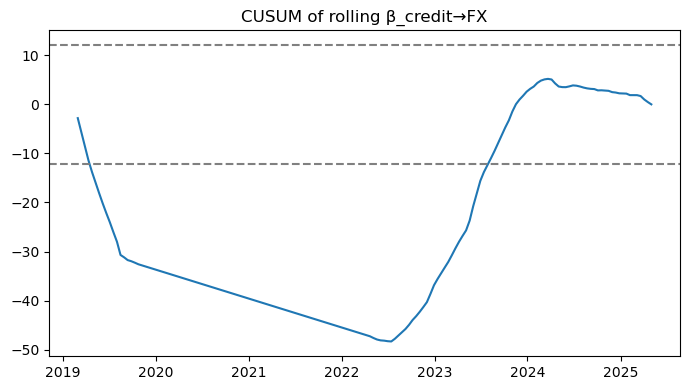

γ_FX→credit   :  CUSUM = 2.495  > 1.630?   p = 0.0000


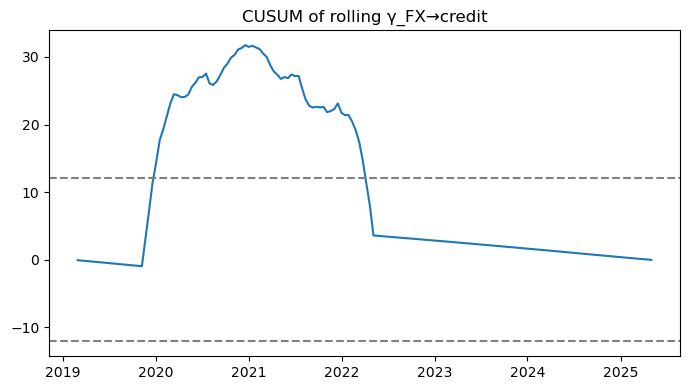

In [85]:
# --- CUSUM stability check for rolling-VAR coefficients -------------------
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.stats.diagnostic import breaks_cusumolsresid

for name, series in coefs.items():
    y = series.values - series.values.mean()           # demean
    stat, pval, crit = breaks_cusumolsresid(y, ddof=0)

    # force plain scalars
    stat   = np.asarray(stat).ravel()[0]               # .item() also fine
    pval   = np.asarray(pval).ravel()[0]
    crit95 = np.asarray(crit).ravel()[1]               # second value = 95 %

    print(f"{name:14s}:  CUSUM = {stat:.3f}  > {crit95:.3f}?   p = {pval:.4f}")

    # -------- optional quick plot ----------------------------------------
    s  = np.cumsum((series - series.mean()) / series.std(ddof=0))
    b  = 0.948 * np.sqrt(len(s))                       # 95 % boundary

    plt.figure(figsize=(7,4))
    plt.plot(series.index, s, label='CUSUM')
    plt.axhline( b, color='grey', ls='--')
    plt.axhline(-b, color='grey', ls='--')
    plt.title(f'CUSUM of rolling {name}')
    plt.tight_layout()
    plt.show()


6 Where exactly is the break? — plot the cumulative sums

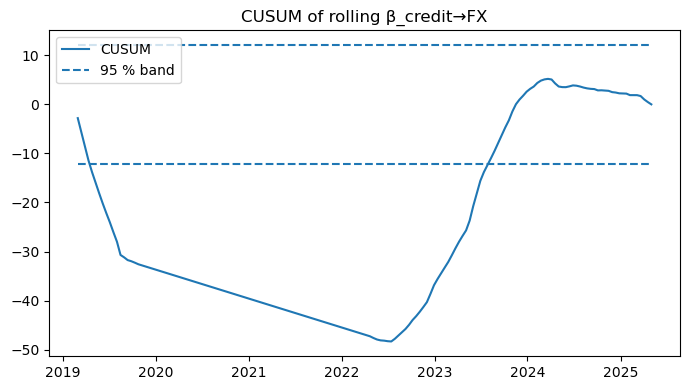

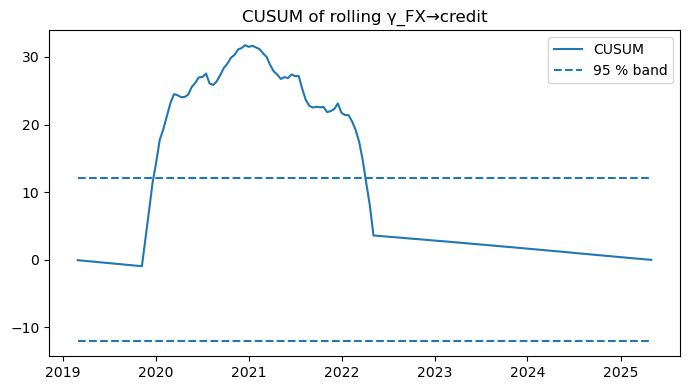

In [87]:
for name in coefs:
    s  = np.cumsum((coefs[name] - coefs[name].mean()) / coefs[name].std(ddof=0))
    t  = coefs.index
    b  = 0.948 * np.sqrt(len(s))          # 95 % boundary

    plt.figure()
    plt.plot(t, s, label='CUSUM')
    plt.hlines([b, -b], t[0], t[-1], ls='--', label='95 % band')
    plt.title(f'CUSUM of rolling {name}')
    plt.legend();  plt.tight_layout()
    plt.show()


In [89]:
crises = pd.to_datetime([
    '2013-05-22',   # taper tantrum
    '2018-09-04',   # IL&FS / NBFC stress
    '2020-03-12',   # Covid-19 sell-off
])

closest = [min(crises, key=lambda d: abs(d - date)) for date in coefs.index]
comparison = pd.DataFrame({
    'β_break?': np.abs(coefs.index - crises[:, None]).min(axis=0) <= pd.Timedelta('90D')
}, index=coefs.index)

print(comparison[comparison['β_break?']])


ValueError: Multi-dimensional indexing (e.g. `obj[:, None]`) is no longer supported. Convert to a numpy array before indexing instead.

In [91]:
import numpy as np
import pandas as pd

# -- crisis dates ----------------------------------------------------------
crises = pd.to_datetime([
    "2013-05-22",   # taper tantrum
    "2018-09-04",   # IL&FS / NBFC stress
    "2020-03-12",   # COVID-19 sell-off
])

# -- Boolean: is each window-end date within ±90 days of ANY crisis? -------
crises_arr = crises.values                   # numpy datetime64[ns]  (shape = (3,))
coefs_arr  = coefs.index.values              # numpy datetime64[ns]  (shape = (T,))

within_90d = (
    np.abs(coefs_arr[:, None] - crises_arr)  # (T,3) matrix of |Δt|
    .min(axis=1)                             # closest crisis for each date
    <= np.timedelta64(90, "D")               # threshold
)

comparison = pd.DataFrame({"β_break?": within_90d}, index=coefs.index)
print(comparison[comparison["β_break?"]])


            β_break?
2019-12-20      True
2020-01-03      True
2020-01-17      True
2020-01-31      True
2020-02-14      True
2020-02-28      True
2020-03-13      True
2020-03-27      True
2020-04-10      True
2020-04-24      True
2020-05-08      True
2020-05-22      True
2020-06-05      True
